### Denoising Autoencoders And Where To Find Them (5 points)

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [3]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)

/opt/conda/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/opt/conda/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


X shape: (13143, 38, 38, 3)
attr shape: (13143, 73)


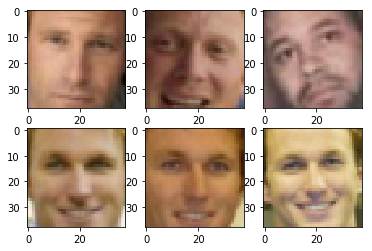

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as two sequential keras models: the encoder and decoder respectively.

We will then use symbolic API to apply and train those models.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



In [1]:
!pip install --upgrade numpy

    100% |################################| 17.2MB 75kB/s  eta 0:00:01  29% |#########                       | 5.1MB 7.3MB/s eta 0:00:02
  Found existing installation: numpy 1.13.1
    Uninstalling numpy-1.13.1:
      Successfully uninstalled numpy-1.13.1


In [ ]:
!pip install tensorflow
!pip install keras

In [2]:
import tensorflow as tf
import keras, keras.layers as L
s = keras.backend.get_session()

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [6]:
def build_pca_autoencoder(img_shape,code_size=32):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

Meld them together into one model

In [7]:
encoder,decoder = build_pca_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [8]:
autoencoder.fit(x=X_train,y=X_train,epochs=32,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/32
11828/11828 [==============================] - 4s 302us/step - loss: 0.0271 - val_loss: 0.0184
Epoch 2/32
11828/11828 [==============================] - 3s 273us/step - loss: 0.0159 - val_loss: 0.0142
Epoch 3/32
11828/11828 [==============================] - 3s 274us/step - loss: 0.0127 - val_loss: 0.0119
Epoch 4/32
11828/11828 [==============================] - 3s 271us/step - loss: 0.0109 - val_loss: 0.0104
Epoch 5/32
11828/11828 [==============================] - 3s 274us/step - loss: 0.0096 - val_loss: 0.0092
Epoch 6/32
11828/11828 [==============================] - 3s 270us/step - loss: 0.0084 - val_loss: 0.0081
Epoch 7/32
11828/11828 [==============================] - 3s 270us/step - loss: 0.0075 - val_loss: 0.0074
Epoch 8/32
11828/11828 [==============================] - 3s 267us/step - loss: 0.0068 - val_loss: 0.0065
Epoch 9/32
11828/11828 [==============================] - 3s 268us/step - loss: 0.0062 - val_loss: 0.00

In [9]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1))
    plt.show()


Final MSE: 0.007394294156391925


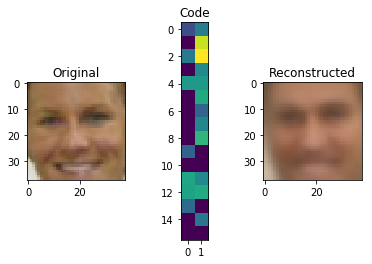

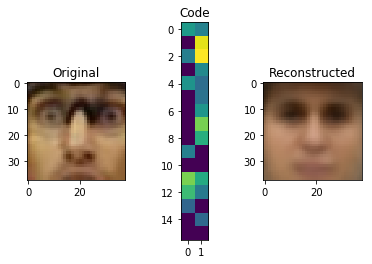

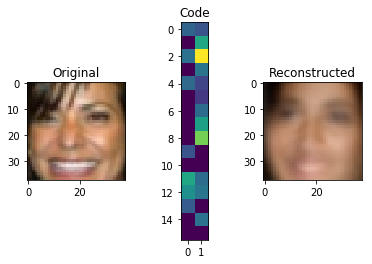

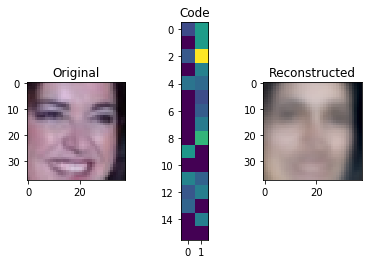

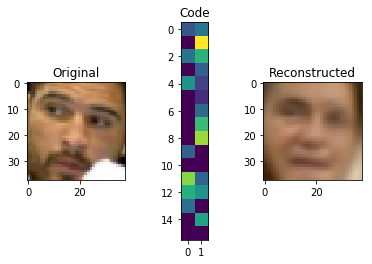

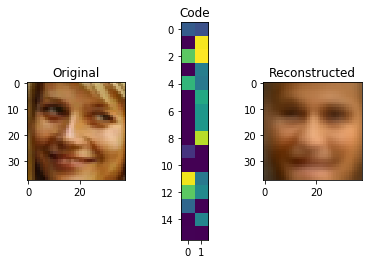

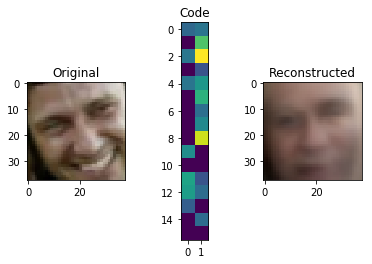

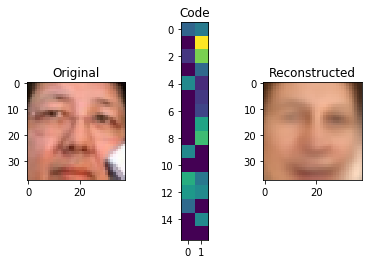

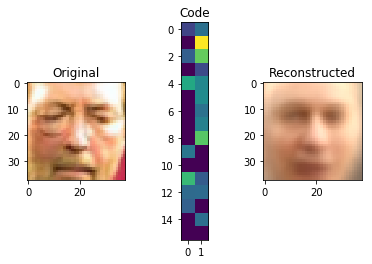

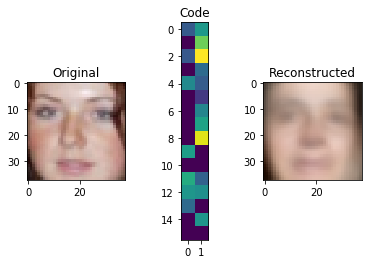

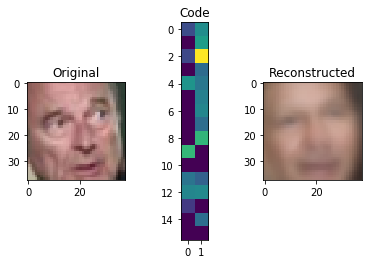

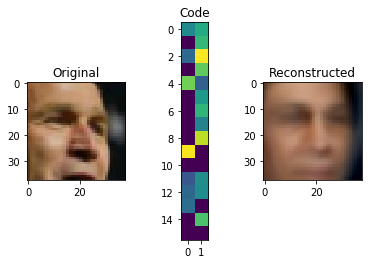

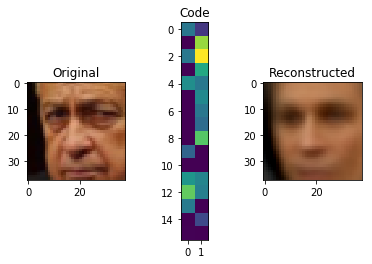

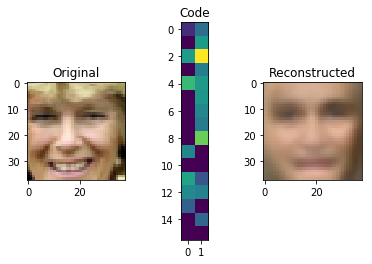

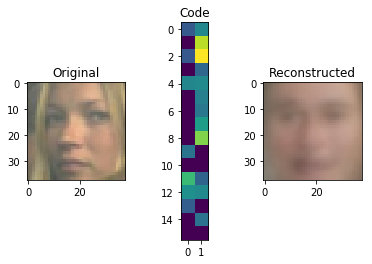

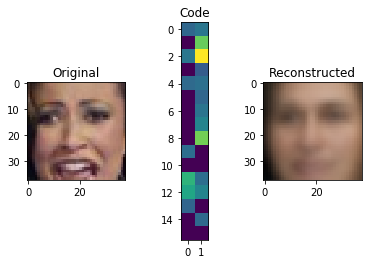

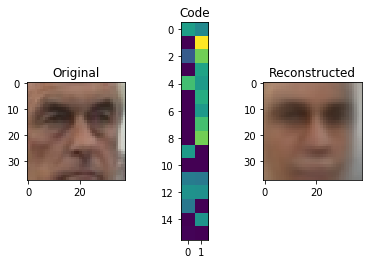

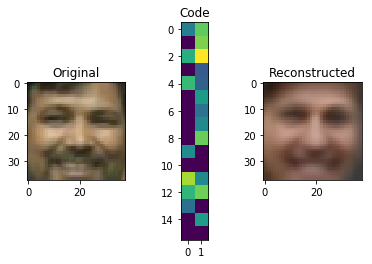

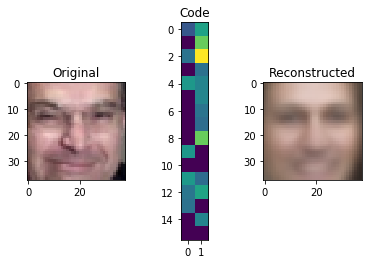

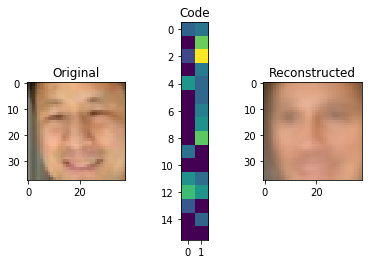

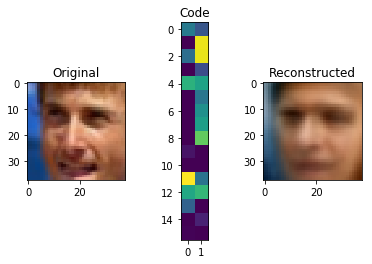

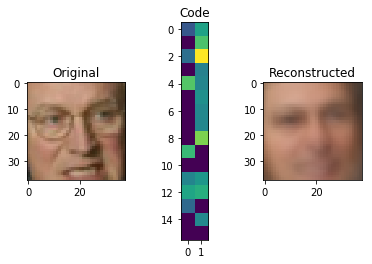

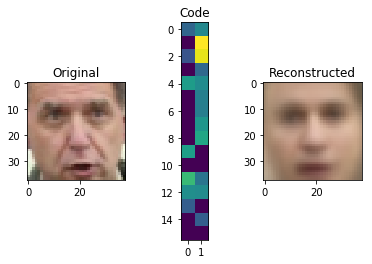

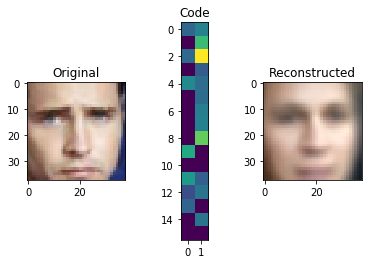

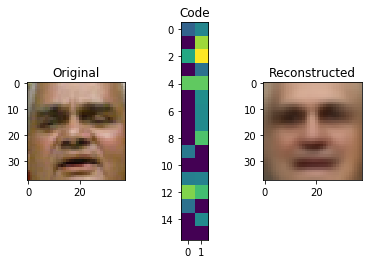

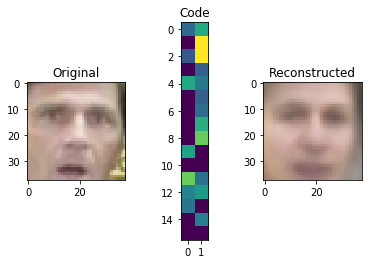

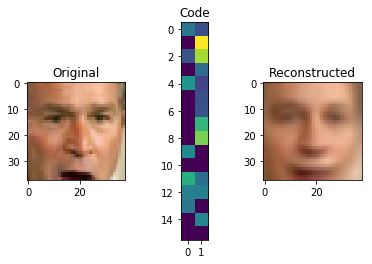

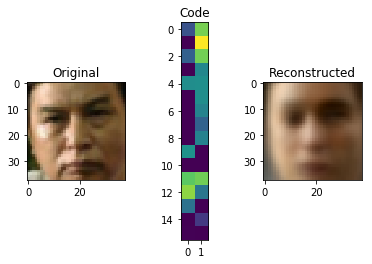

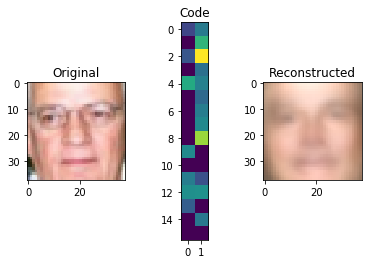

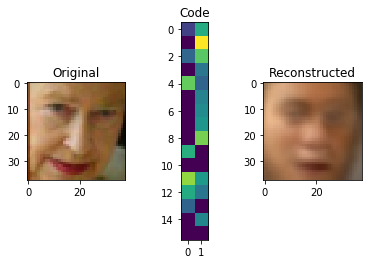

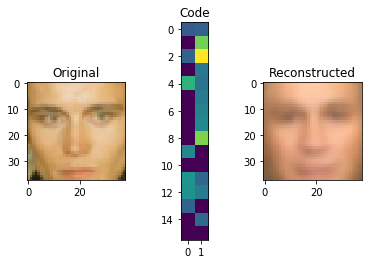

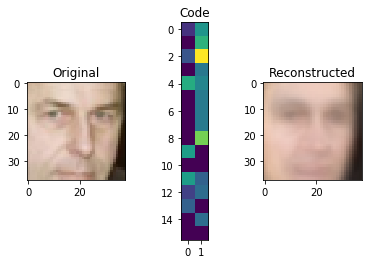

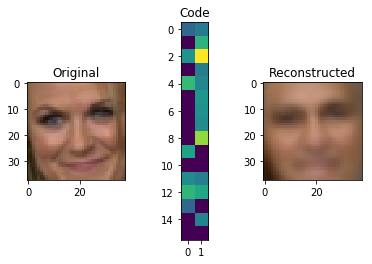

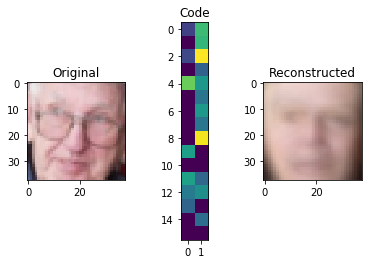

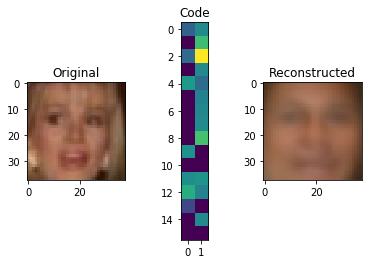

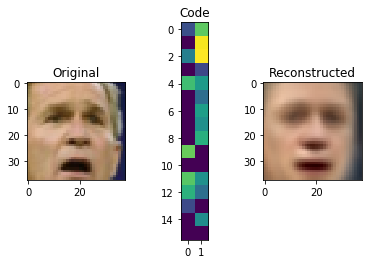

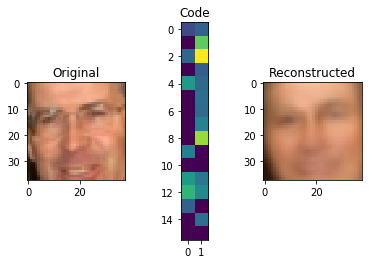

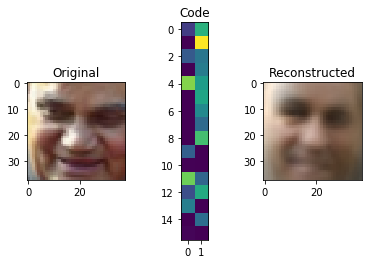

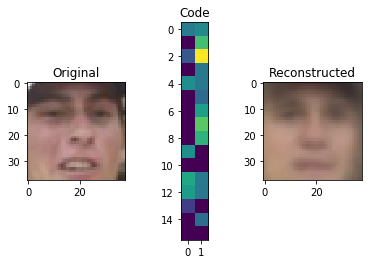

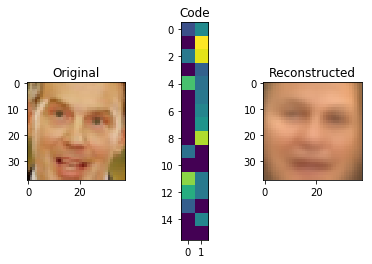

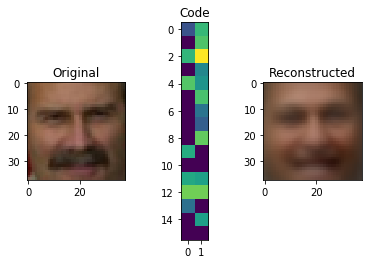

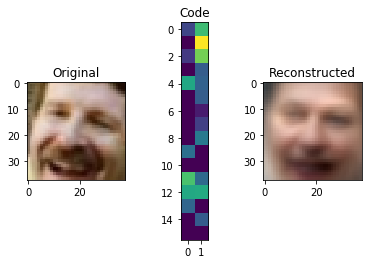

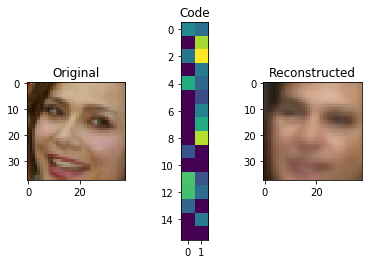

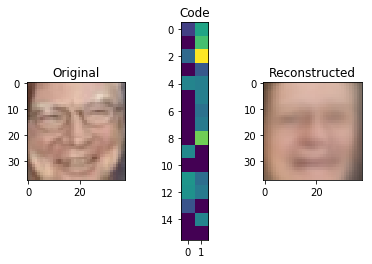

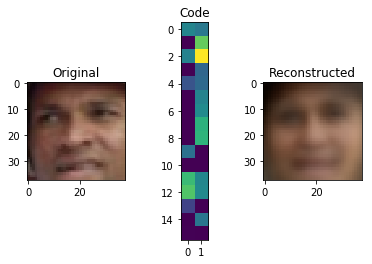

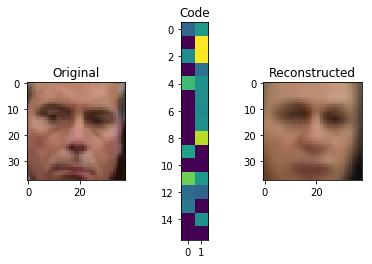

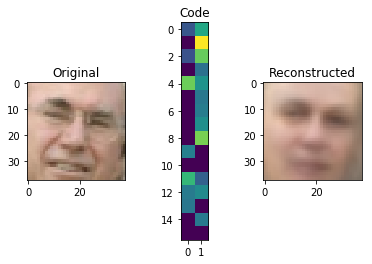

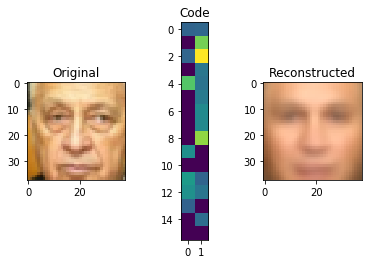

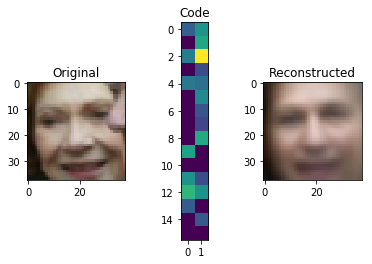

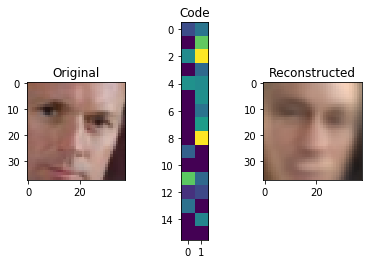

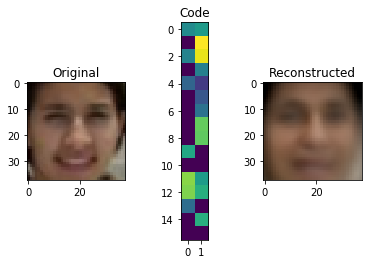

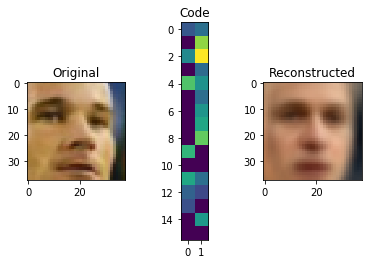

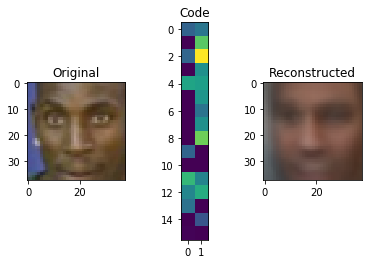

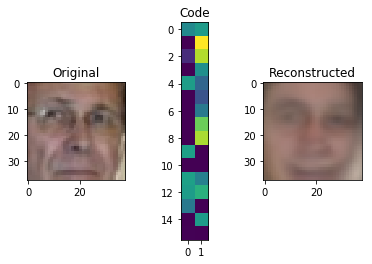

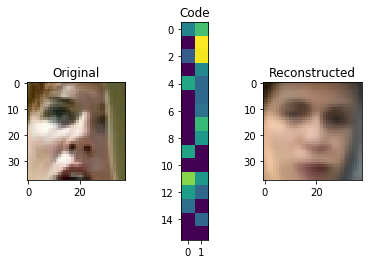

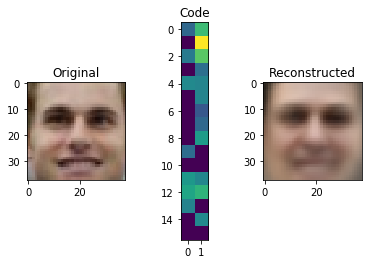

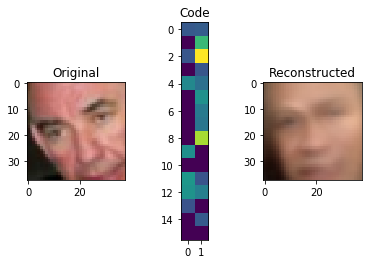

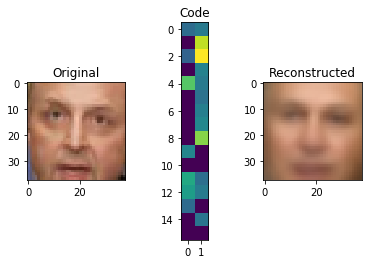

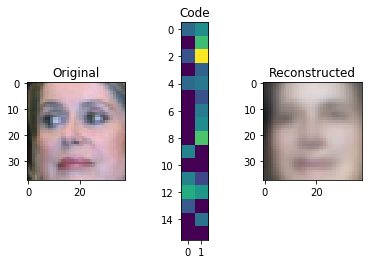

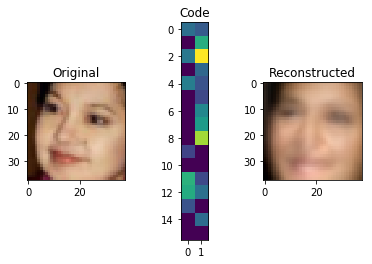

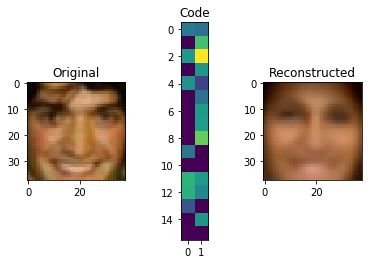

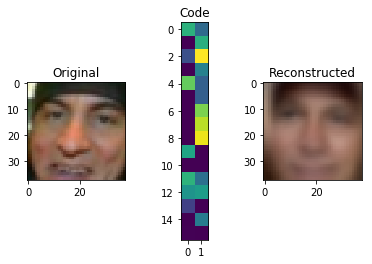

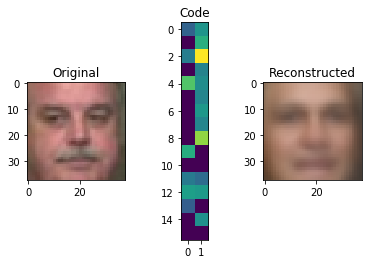

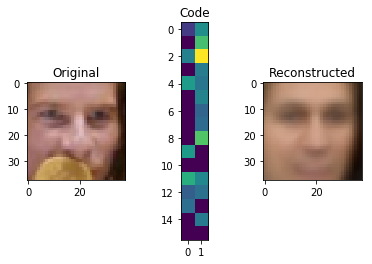

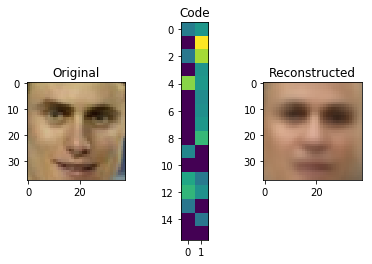

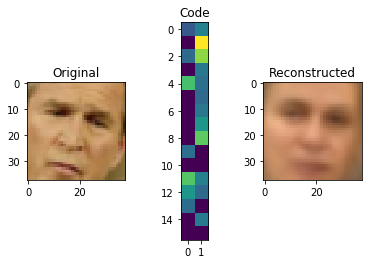

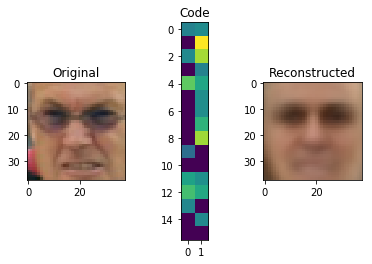

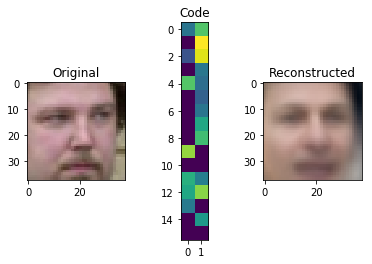

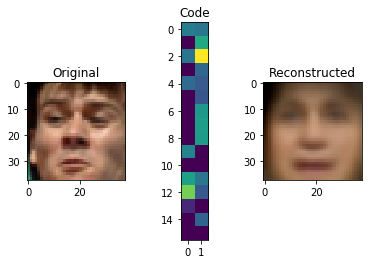

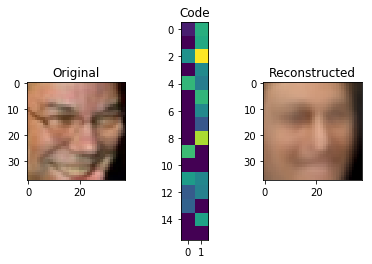

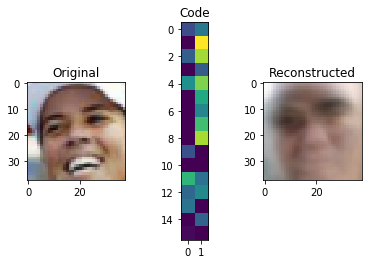

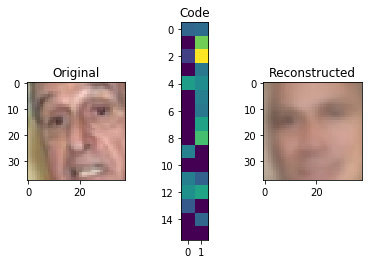

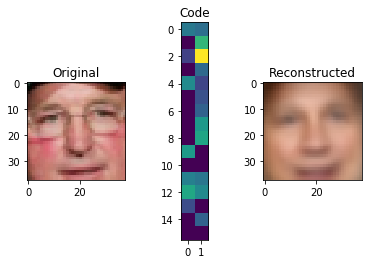

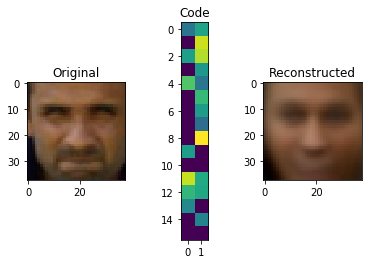

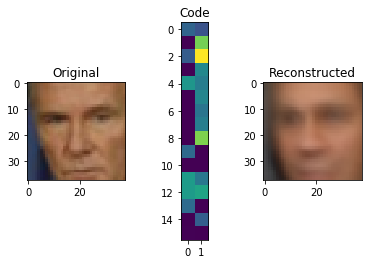

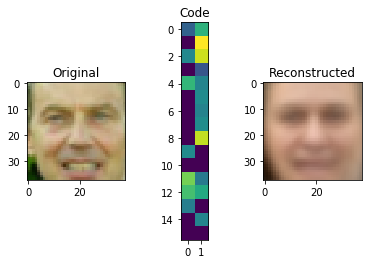

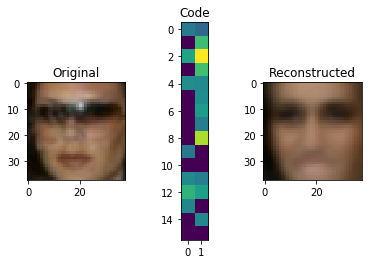

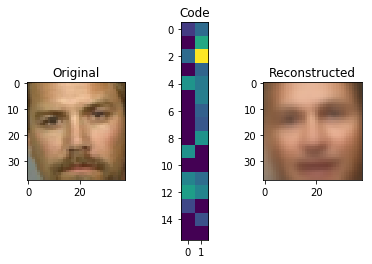

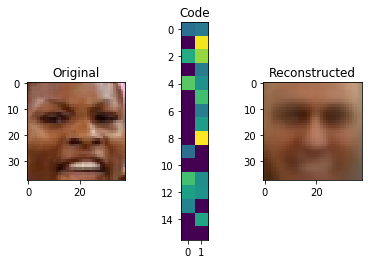

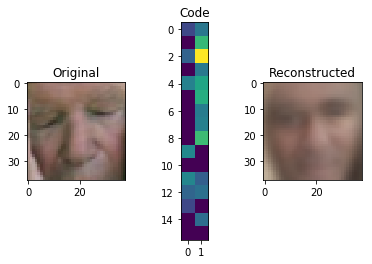

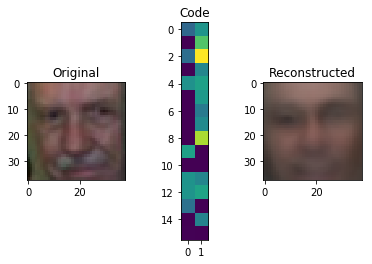

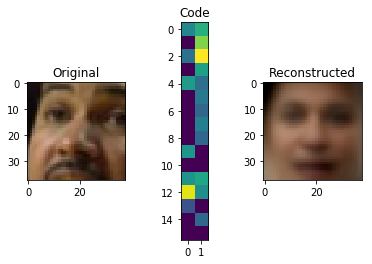

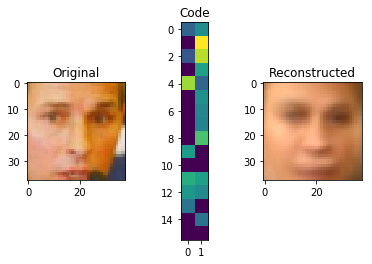

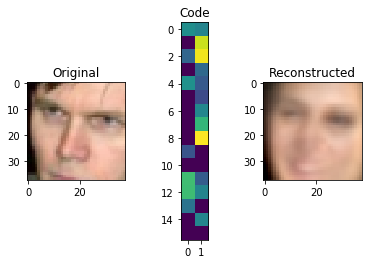

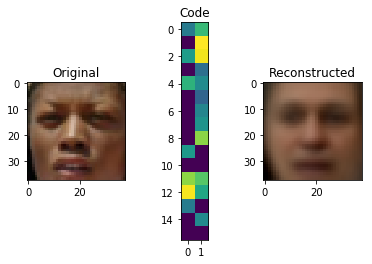

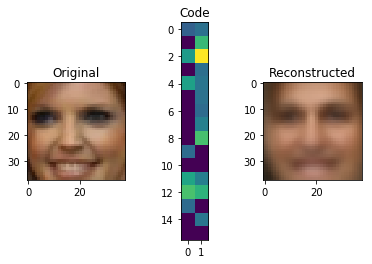

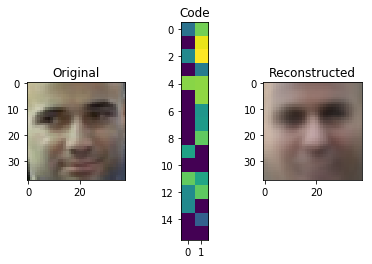

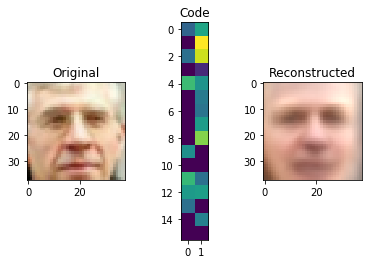

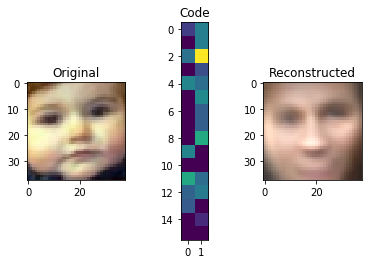

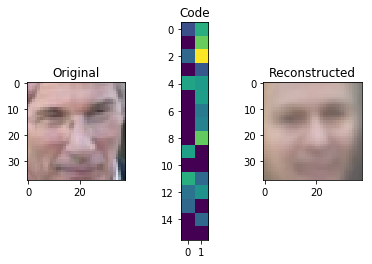

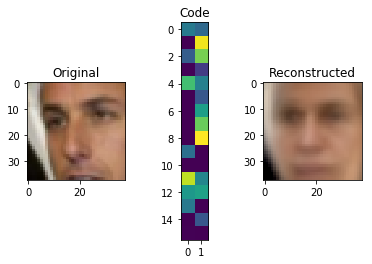

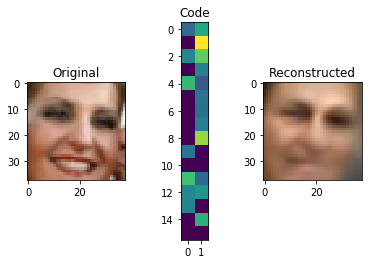

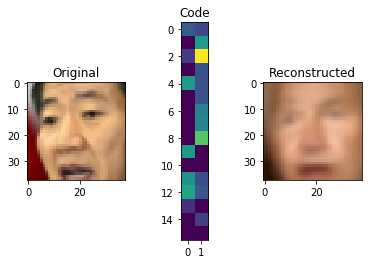

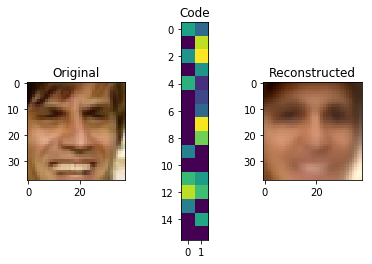

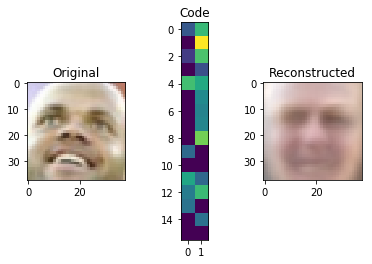

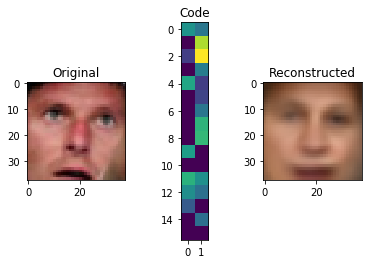

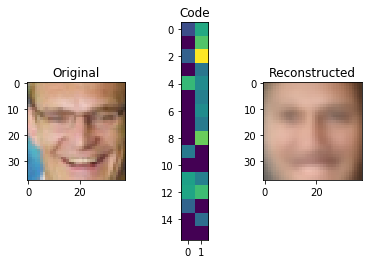

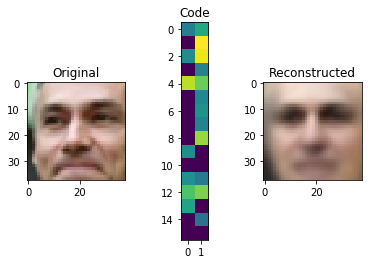

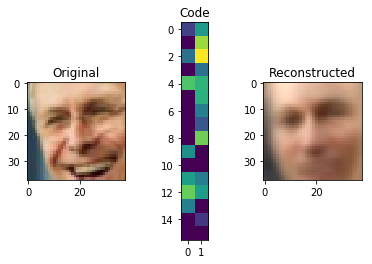

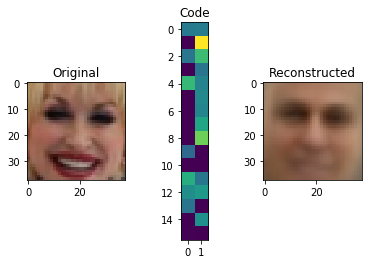

In [33]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("Final MSE:",score)

for i in range(100):
    img = X_test[i]
    visualize(img,encoder,decoder)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [15]:
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder
    encoder.add(L.Activation("elu"))
    encoder.add(L.Dense(code_size))           #actual encoder
    encoder.add(L.Activation("elu"))
    encoder.add(L.Dense(code_size))           #actual encoder
    encoder.add(L.Activation("elu"))
    
    #<Your code: define encoder as per instructions above>
    
    
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder.add(L.Dense(code_size))           #actual encoder
    decoder.add(L.Activation("elu"))
    decoder.add(L.Dense(code_size))           #actual encoder
    decoder.add(L.Activation("elu"))
    decoder.add(L.Dense(code_size))           #actual encoder
    decoder.add(L.Activation("elu"))
    
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))

    #<Your code: define encoder as per instructions above>    
    
    return encoder,decoder

In [16]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    encoder,decoder = build_deep_autoencoder(img_shape,code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==img_shape,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 dense layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 dense layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [17]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

Training may take some 20 minutes.

In [21]:
autoencoder.fit(x=X_train,y=X_train,epochs=128,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/128
11828/11828 [==============================] - 4s 299us/step - loss: 0.0080 - val_loss: 0.0082
Epoch 2/128
11828/11828 [==============================] - 4s 310us/step - loss: 0.0080 - val_loss: 0.0082
Epoch 3/128
11828/11828 [==============================] - 4s 300us/step - loss: 0.0080 - val_loss: 0.0082
Epoch 4/128
11828/11828 [==============================] - 4s 301us/step - loss: 0.0080 - val_loss: 0.0082
Epoch 5/128
11828/11828 [==============================] - 4s 301us/step - loss: 0.0080 - val_loss: 0.0082
Epoch 6/128
11828/11828 [==============================] - 4s 297us/step - loss: 0.0080 - val_loss: 0.0082
Epoch 7/128
11828/11828 [==============================] - 4s 306us/step - loss: 0.0080 - val_loss: 0.0082
Epoch 8/128
11828/11828 [==============================] - 4s 302us/step - loss: 0.0079 - val_loss: 0.0082
Epoch 9/128
11828/11828 [==============================] - 4s 302us/step - loss: 0.0079 - val_l

11828/11828 [==============================] - 4s 309us/step - loss: 0.0072 - val_loss: 0.0074
Epoch 77/128
11828/11828 [==============================] - 4s 305us/step - loss: 0.0072 - val_loss: 0.0074
Epoch 78/128
11828/11828 [==============================] - 4s 302us/step - loss: 0.0072 - val_loss: 0.0074
Epoch 79/128
11828/11828 [==============================] - 4s 316us/step - loss: 0.0072 - val_loss: 0.0074
Epoch 80/128
11828/11828 [==============================] - 4s 299us/step - loss: 0.0072 - val_loss: 0.0074
Epoch 81/128
11828/11828 [==============================] - 4s 301us/step - loss: 0.0072 - val_loss: 0.0074
Epoch 82/128
11828/11828 [==============================] - 4s 301us/step - loss: 0.0072 - val_loss: 0.0074
Epoch 83/128
11828/11828 [==============================] - 4s 303us/step - loss: 0.0072 - val_loss: 0.0074
Epoch 84/128
11828/11828 [==============================] - 4s 306us/step - loss: 0.0072 - val_loss: 0.0074
Epoch 85/128
11828/11828 [===============

KeyboardInterrupt: 

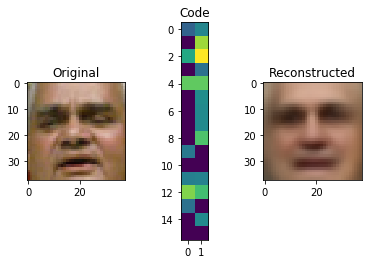

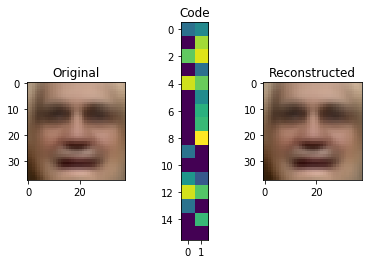

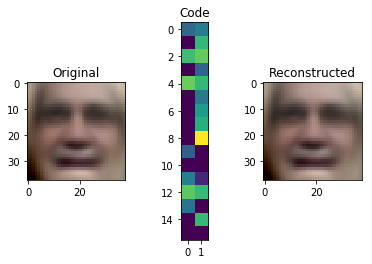

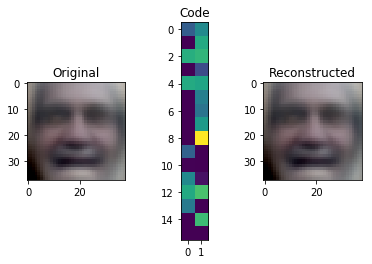

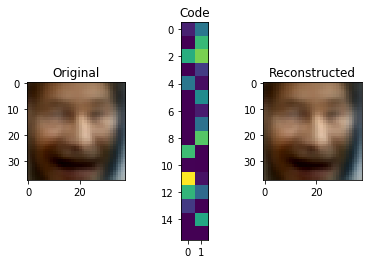

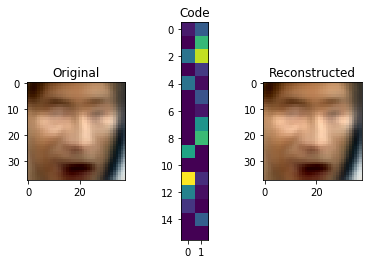

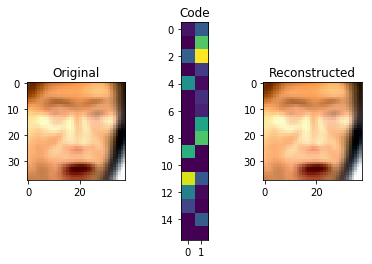

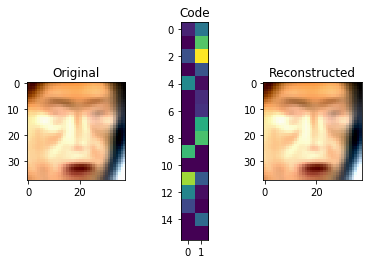

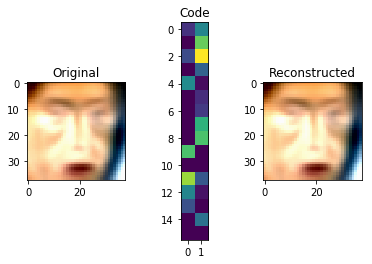

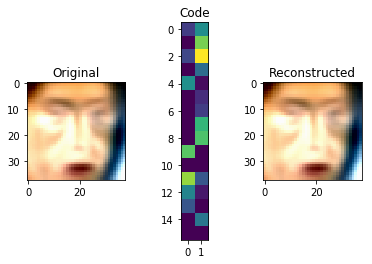

In [40]:
img=X_test[24]
for i in range(100):
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]
    reco=reco.clip(0,1)
    reco*=0.99
    if(i%10==0):
        plt.subplot(1,3,1)
        plt.title("Original")
        plt.imshow(img)

        plt.subplot(1,3,2)
        plt.title("Code")
        plt.imshow(code.reshape([code.shape[-1]//2,-1]))

        plt.subplot(1,3,3)
        plt.title("Reconstructed")
        plt.imshow(reco.clip(0,1))
        plt.show()
    img=reco

Final MSE: 0.007394294156391925


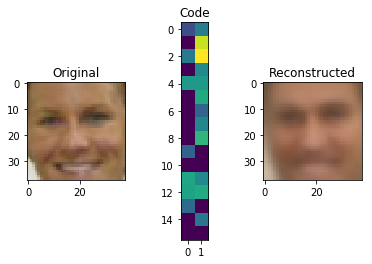

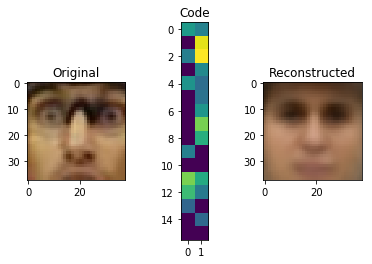

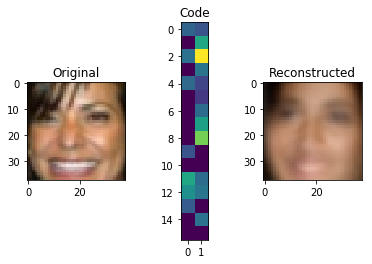

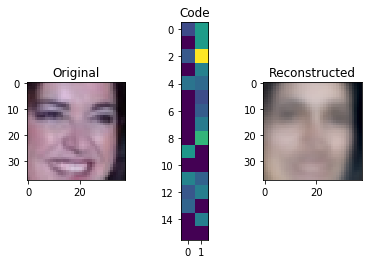

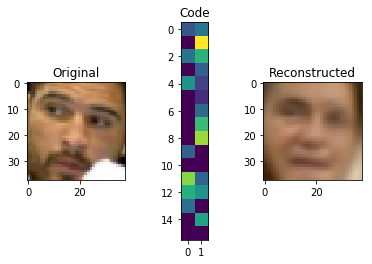

In [22]:
reconstruction_mse = autoencoder.evaluate(X_test,X_test,verbose=0)
#assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
#assert len(encoder.output_shape)==2 and encoder.output_shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [ ]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    <your code here>
        
    return X + noise
    

In [ ]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

In [ ]:
plt.subplot(1,4,1)
plt.imshow(X[0])
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0])

In [ ]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [ ]:
for i in range(50):
    print("Epoch %i/50, Generating corrupted samples..."%i)
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    autoencoder.fit(x=X_train_noise,y=X_train,epochs=1,
                    validation_data=[X_test_noise,X_test])

__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

In [ ]:
denoising_mse = autoencoder.evaluate(apply_gaussian_noise(X_test),X_test,verbose=0)
print("Final MSE:", denoising_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [ ]:
encoder.save("./encoder.h5")
decoder.save("./decoder.h5")

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [ ]:
images = X_train
codes = <encode all images>
assert len(codes) == len(images)

In [ ]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [ ]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
#smiles
show_similar(X_test[2])

In [ ]:
#ethnicity
show_similar(X_test[500])

In [ ]:
#glasses
show_similar(X_test[66])

## Bonus: cheap image morphing


In [ ]:

for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1,image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        plt.imshow(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.